# Benchmark

We now need to find out how good the grid is. To do this we first create several homogeneous grids with 1,000 to 100,000 gridpoints and calculate the correlations. The correlations calculated with the 100,000 gridpoint grid will be taken as a reference. Secondly, we create grids with several dense areas again with an increasing number of gridpoints. All grids will only have gridpoints in the ocean. The noisesource distribution will be homogeneous in all cases. Finally, we will compute the L2 misfit of the correlations using the 100,000 gridpoint grid as a reference. 

The first step is to get the parameters for the different grids. 
Let's say we what 13 grids with gridpoints [1000, 2500, 5000, 7500, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 100000]. The parameters we need to set are:

- sigma 
- beta
- phi_ini
- phi_max
- lat_0
- lon_0
- n
- gamma

For the homogeneous grids we only really need to set phi_ini and make phi_max = phi_ini.

For the gaussian grids we set the center of the background in the north-atlantic and add a slightly denser grid in the Indian Ocean. 

In [7]:
# Run if start again
os.chdir(main_path)
print(os.getcwd())

/Users/jigel/noisi


In [8]:
import os
import io
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pandas import read_csv
from pandas import DataFrame
main_path = os.getcwd()
print(main_path)

n_cores = 8
print(n_cores)

/Users/jigel/noisi
8


In [9]:
# homogeneous grids

gridpoints_homo = [1018,2543,5092,7499,10071,20125,30048,40748,50993,60079,70771,81857,101004]

phi_ini_homo = [5.4,3.4,2.4,1.98,1.71,1.21,0.99,0.85,0.76,0.7,0.645,0.6,0.54]

sigma_homo = [10]*13
beta_homo = [5]*13
phi_max_homo = phi_ini_homo
lat_0_homo = [0]*13
lon_0_homo = [0]*13
n_homo = [1000]*13
gamma_homo = [0]*13


In [10]:
# multiple gaussian grids

gridpoints_gauss = [1080,2510,5106,7331,10330,20840,29984,40095,50000,61968,73311,81861,103365]

sigma_gauss = [[10,10],[10,10],[15,15],[16,16],[26,26],[20,20],[23,23],[27,27],[28,28],[31,31],[35,35],[34,34],[3,3]]
beta_gauss = [[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5],[5,5]]
phi_ini_gauss = [[3.5,3.5],[2,2],[1.2,1.2],[1,1],[0.8,0.8],[0.5,0.5],[0.4,0.4],[0.3,0.3],[0.3,0.3],[0.2,0.2],[0.1,0.1],[0.1,0.1],[0.1,0.1]]
phi_max_gauss = [[10,10],[5,5],[4,4],[3,3],[4,4],[4,4],[3,3],[3,3],[2,2],[2,2],[2,2],[1.5,1.5],[1,1]]
lat_0_gauss = [[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16],[50,-16]]
lon_0_gauss = [[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70],[-30,70]]
n_gauss = [[200,200],[200,200],[200,200],[200,200],[200,200],[400,400],[400,400],[400,400],[400,400],[400,400],[400,400],[400,400],[400,400]]
gamma_gauss = [[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40],[0,40]]

In [11]:
# station list input
stationlist_path = os.path.abspath("./stationlist_atlantic_26.csv")

# wavefield input
wavefield_path = os.path.abspath("../axisem/SOLVER/Noisi_10s_repacked/")

============== Homogeneous Grids =================
============= Working on Grid 1 of 13 ================
New project created: BENCHMARK_Homo_1018
Path to new project:  /Users/jigel/noisi/BENCHMARK_Homo_1018
Changed to project directory: /Users/jigel/noisi/BENCHMARK_Homo_1018
Computing grid...
Grid computed and saved as sourcegrid.npy


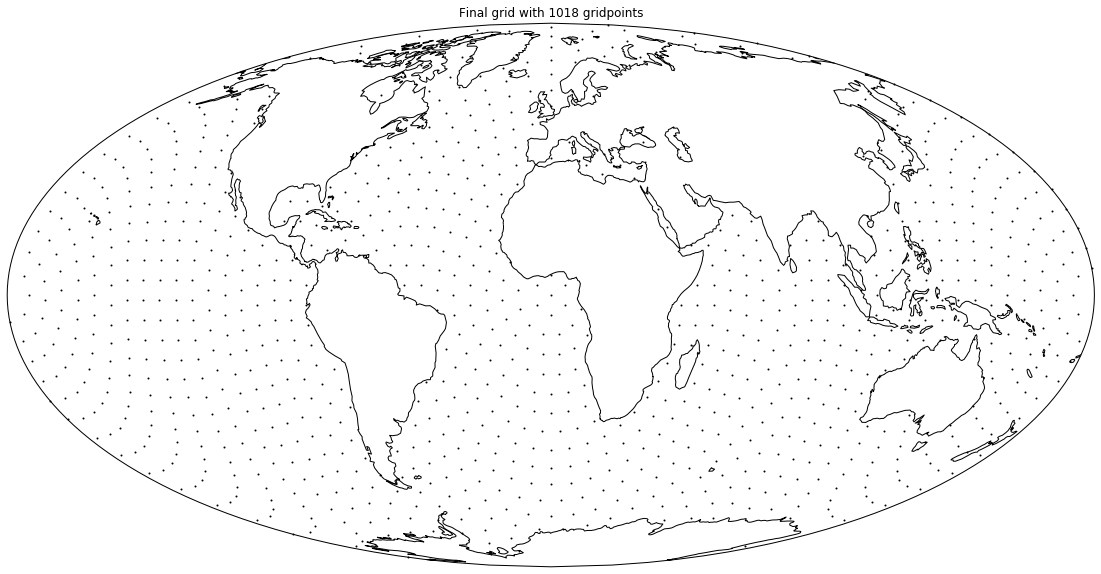

New source created:  /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source
Number of stations:  26
Converting wavefield from instaseis...
CMD:  mpirun -np 8 python /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source/wavefield_from_instaseis.py /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source/source_config.json /Users/jigel/noisi/BENCHMARK_Homo_1018/config.json /Users/jigel/noisi/BENCHMARK_Homo_1018/sourcegrid.npy /Users/jigel/noisi/stationlist_atlantic_26_0.csv /Users/jigel/noisi/BENCHMARK_Homo_1018 : -np 8 python /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source/wavefield_from_instaseis.py /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source/source_config.json /Users/jigel/noisi/BENCHMARK_Homo_1018/config.json /Users/jigel/noisi/BENCHMARK_Homo_1018/sourcegrid.npy /Users/jigel/noisi/stationlist_atlantic_26_1.csv /Users/jigel/noisi/BENCHMARK_Homo_1018 : -np 8 python /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_source/wavefield_from_instaseis.py /Users/jigel/noisi/BENCHMARK_Homo_1018/homo_so

NameError: name 'setup_noisesource_new' is not defined

In [12]:
# Need to create a project for each, then a source, convert wavefield, then calculate correlations
for i in range(0,np.size(gridpoints_homo)):
    print('============== Homogeneous Grids =================')
    print('============= Working on Grid {} of {} ================'.format(i+1,np.size(gridpoints_homo)))
    
    # new project
    project_name = "BENCHMARK_Homo_" + str(gridpoints_homo[i])
    os.system('noisi setup-project ' + project_name)
    print('New project created:', project_name)
    project_path = os.path.join(main_path,project_name)
    print('Path to new project: ', project_path)
    
    # move to project directory
    os.chdir(project_path)
    print('Changed to project directory:',os.getcwd())
    
    # setup grid
    
    # Write to config.json file
    config_path = os.path.join(project_path,'config.json')
    
    with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())
        
    conf['gauss_grid'] = True      
    conf['gauss_sigma'] = [sigma_homo[i]]
    conf['gauss_beta'] = [beta_homo[i]]
    conf['gauss_phi_ini'] = [phi_ini_homo[i]]
    conf['gauss_phi_max'] = [phi_max_homo[i]]
    conf['gauss_lat_0'] = [lat_0_homo[i]]
    conf['gauss_lon_0'] = [lon_0_homo[i]]
    conf['gauss_n'] = [n_homo[i]]
    conf['gauss_gamma'] = [gamma_homo[i]]
    conf['gauss_plot'] = False
    conf['gauss_dense_antipole'] = False
    conf['gauss_only_ocean'] = True

    # Set below to true if voronoi cell surface area is to be calculated
    conf['voronoi_surface_area'] = True

    # change instaseis and wavefield
    conf['instaseis'] = True
    conf['wavefield_path'] = os.path.abspath(wavefield_path)

    with io.open(config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)

    # calculate grid with noisi
    print('Computing grid...')
    os.system('noisi setup-sourcegrid ' + project_path)
    print('Grid computed and saved as sourcegrid.npy')
    
    #plot and save sourcegrid
    sourcegrid_path = os.path.join(project_path,'sourcegrid.npy')
    grid = np.load(sourcegrid_path)

    plt.figure(figsize=(25,10))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.coastlines()
    plt.scatter(grid[0],grid[1],s=1,c='k',transform=ccrs.Geodetic())
    plt.title('Final grid with {} gridpoints'.format(np.size(grid[0])))
    plt.savefig(os.path.join(project_path,"sourcegrid.png"))
    plt.show(block=False)
    
    # Setup a homogeneous source called homo_source
    source_homo = "homo_source"

    source_homo_path = os.path.join(project_path,source_homo)
    os.system ('noisi setup-source ' + source_homo_path)

    print('New source created: ', source_homo_path)

    # Get number of stations for mpi
    stationlist = read_csv(stationlist_path)
    station_n = np.shape(stationlist)[0]
    print('Number of stations: ',station_n)
    
    
    # Convert wavefield 
    # need arguments: source_config, config, sourcegrid, stationlist, output folder

    source_config_path = os.path.join(source_homo_path,'source_config.json')
    wavefield_from_instaseis_path = os.path.join(source_homo_path,'wavefield_from_instaseis.py')

    # New method to avoid oversubscribing
    n_processes = int(np.ceil(station_n/n_cores))

    wf_convert = 'mpirun'
    # make files
    for i in range(0,n_processes):
        file_name = 'stationlist_atlantic_26_'+str(i)
        file_name_path = os.path.join(main_path,file_name+'.csv')
        stationlist[i*n_cores:(i+1)*n_cores].to_csv(file_name_path,index=None,header=True)
        wf_convert += ' -np {} python {} {} {} {} {} {} :'.format(n_cores,wavefield_from_instaseis_path,source_config_path,config_path,sourcegrid_path,file_name_path,project_path)
    # get rid of last :
    wf_convert = wf_convert[:-1]

    print('Converting wavefield from instaseis...')
    print('CMD: ',wf_convert)
    os.system(wf_convert)
    print('Done.')
    
    wavefield_processed_path = os.path.join(project_path,'wavefield_processed')

    
    # Change config.json file
    with io.open(config_path,'r+') as fh:
            conf = json.loads(fh.read())

    # change instaseis and wavefield
    conf['instaseis'] = False
    conf['wavefield_path'] = os.path.abspath(wavefield_processed_path)

    with io.open(config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)
        
        
    # Change source_config file
    source_config_path = os.path.join(source_homo_path,'source_config.json')

    with io.open(source_config_path,'r+') as fh:
            conf = json.loads(fh.read())

            
    # change instaseis and wavefield
    conf['max_lag'] = 2500
    conf['preprocess_do'] = False
    conf ['project_name'] = project_name
    conf ['project_path'] = project_path
    with io.open(source_config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)
        
    # setup noise source for homogeneous model

    print('Setting up noisesource distribution...')
    setup_noisesource_new(project_path,source_homo_path)
    print('Done.')
    
    
    # calculate correlations for homogeneous source
    print("Computing correlations...")
    os.system("mpirun -np 8 noisi correlation {} {}".format(source_homo_path,0))
    print("All correlations computed.")
    
    # plot correlations and save the file
    corr_homo_path = os.path.join(source_homo_path,"step_0/corr")

    # make azimuth selection
    traces_homo =plot_section(corr_homo_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                          scale = 1., resol = 1,plot=False)
    
    #plot
    maxlag = (traces_homo[0].stats.npts-1) / 2.0
    
    traces_homo.plot(type='section',orientation='horizontal',
    reftime = traces_homo[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'homo_correlations.png'))


    # Go back to main directory
    os.chdir(main_path)
    print('Back to main directory:',os.getcwd())
    
    
    
print('=======================================')  
print('======= HOMOGENEOUS GRIDS DONE ========')
print('=======================================')  

    

In [ ]:
# Need to create a project for each, then a source, convert wavefield, then calculate correlations

for i in range(0,np.size(gridpoints_gauss)):
    print('============= Gaussian Grids ===============')
    print('============= Working on Grid {} of {} ================'.format(i+1,np.size(gridpoints_gauss)))
    
    # new project
    project_name = "BENCHMARK_Gauss_" + str(gridpoints_gauss[i])
    os.system('noisi setup-project ' + project_name)
    print('New project created:', project_name)
    project_path = os.path.join(os.getcwd(),project_name)
    print('Path to new project: ', project_path)
        
    # move to project directory
    os.chdir(project_path)
    print('Changed to project directory:',os.getcwd())
    
    # setup grid
    
    # Write to config.json file
    config_path = os.path.join(project_path,'config.json')
    
    with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())
        
    conf['gauss_grid'] = True      
    conf['gauss_sigma'] = [sigma_gauss[i]]
    conf['gauss_beta'] = [beta_gauss[i]]
    conf['gauss_phi_ini'] = [phi_ini_gauss[i]]
    conf['gauss_phi_max'] = [phi_max_gauss[i]]
    conf['gauss_lat_0'] = [lat_0_gauss[i]]
    conf['gauss_lon_0'] = [lon_0_gauss[i]]
    conf['gauss_n'] = [n_gauss[i]]
    conf['gauss_gamma'] = [gamma_gauss[i]]
    conf['gauss_plot'] = False
    conf['gauss_dense_antipole'] = False
    conf['gauss_only_ocean'] = True

    # Set below to true if voronoi cell surface area is to be calculated
    conf['voronoi_surface_area'] = True

    # change instaseis and wavefield
    conf['instaseis'] = True
    conf['wavefield_path'] = os.path.abspath(wavefield_path)

    with io.open(config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)

    # calculate grid with noisi
    print('Computing grid...')
    os.system('noisi setup-sourcegrid ' + project_path)
    print('Grid computed and saved as sourcegrid.npy')
    
    #plot and save sourcegrid
    sourcegrid_path = os.path.join(project_path,'sourcegrid.npy')
    grid = np.load(sourcegrid_path)

    plt.figure(figsize=(25,10))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.coastlines()
    plt.scatter(grid[0],grid[1],s=1,c='k',transform=ccrs.Geodetic())
    plt.title('Final grid with {} gridpoints'.format(np.size(grid[0])))
    plt.savefig(os.path.join(project_path,"sourcegrid.png"))
    plt.show(block=False)
    
    # Setup a homogeneous source called homo_source
    source_homo = "homo_source"

    source_homo_path = os.path.join(project_path,source_homo)
    os.system ('noisi setup-source ' + source_homo_path)

    print('New source created: ', source_homo_path)

    # Get number of stations for mpi
    stationlist = read_csv(stationlist_path)
    station_n = np.shape(stationlist)[0]
    print('Number of stations: ',station_n)
    
    
    # Convert wavefield 
    # need arguments: source_config, config, sourcegrid, stationlist, output folder

    source_config_path = os.path.join(source_homo_path,'source_config.json')
    wavefield_from_instaseis_path = os.path.join(source_homo_path,'wavefield_from_instaseis.py')

    print('Converting wavefield from instaseis...')
    os.system('mpirun -np {} python {} {} {} {} {} {}'.format(station_n,wavefield_from_instaseis_path,source_config_path,config_path,sourcegrid_path,stationlist_path,project_path))
    print('Done.')
    
    wavefield_processed_path = os.path.join(project_path,'wavefield_processed')

    # Change config.json file
    with io.open(config_path,'r+') as fh:
            conf = json.loads(fh.read())

    # change instaseis and wavefield
    conf['instaseis'] = False
    conf['wavefield_path'] = os.path.abspath(wavefield_processed_path)

    with io.open(config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)
        
        
    # Change source_config file
    source_config_path = os.path.join(source_homo_path,'source_config.json')

    with io.open(source_config_path,'r+') as fh:
            conf = json.loads(fh.read())
        
    # change instaseis and wavefield
    conf['max_lag'] = 2500
    conf['preprocess_do'] = False
    conf ['project_name'] = project_name
    conf ['project_path'] = project_path
    with io.open(source_config_path,'w') as fh:
        cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
        fh.write(cf)
        
    # setup noise source for homogeneous model

    print('Setting up noisesource distribution...')
    setup_noisesource_new(project_path,source_homo_path)
    print('Done.')
    
    
    # calculate correlations for homogeneous source
    print("Computing correlations...")
    os.system("mpirun -np 8 noisi correlation {} {}".format(source_homo_path,0))
    print("All correlations computed.")
    
    # plot correlations and save the file
    corr_homo_path = os.path.join(source_homo_path,"step_0/corr")

    # make azimuth selection
    traces_homo =plot_section(corr_homo_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                          scale = 1., resol = 1,plot=False)
    #plot
    maxlag = (traces_homo[0].stats.npts-1) / 2.0
    traces_homo.plot(type='section',orientation='horizontal',
    reftime = traces_homo[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'homo_correlations.png'))


    
    # Go back to main directory
    os.chdir(main_path)
    print('Back to main directory:',os.getcwd())
    
print('=======================================')  
print('======== GAUSSIAN GRIDS DONE ==========')
print('=======================================')     
    
    
print('======== BENCHMARK DONE =========')

